## Bonus (version s/ outliers)
#### Respecto a la implementación de los modelos, esta versión es idéntica a `regresion.ipynb`, pero mejora levemente las métricas a través de la detección de los outliers más extremos y su remplazo por la mediana.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

# California Housing

Este es un [dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) muy popular que vamos a leer desde **Scikit-Learn**.

Se requiere construir un modelo de regresión que nos permita predecir el valor medio de las casas en distintos distritos de California (medido en cientos de miles de dólares, es decir, $100,000). Este conjunto de datos proviene del censo de EE. UU. de 1990, donde cada observación corresponde a un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (típicamente con una población de entre 600 y 3,000 personas).


Un hogar es un grupo de personas que residen dentro de una misma vivienda. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores altos en bloques con pocos hogares y muchas viviendas vacías.

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio del bloque
- `HouseAge`: Edad mediana de las viviendas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar
- `AveBedrms`: Número promedio de dormitorios por hogar
- `Population`: Población del bloque
- `AveOccup`: Número promedio de personas por hogar
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

In [42]:
# Lectura del dataset
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

In [43]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [44]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [45]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [46]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [47]:
X.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

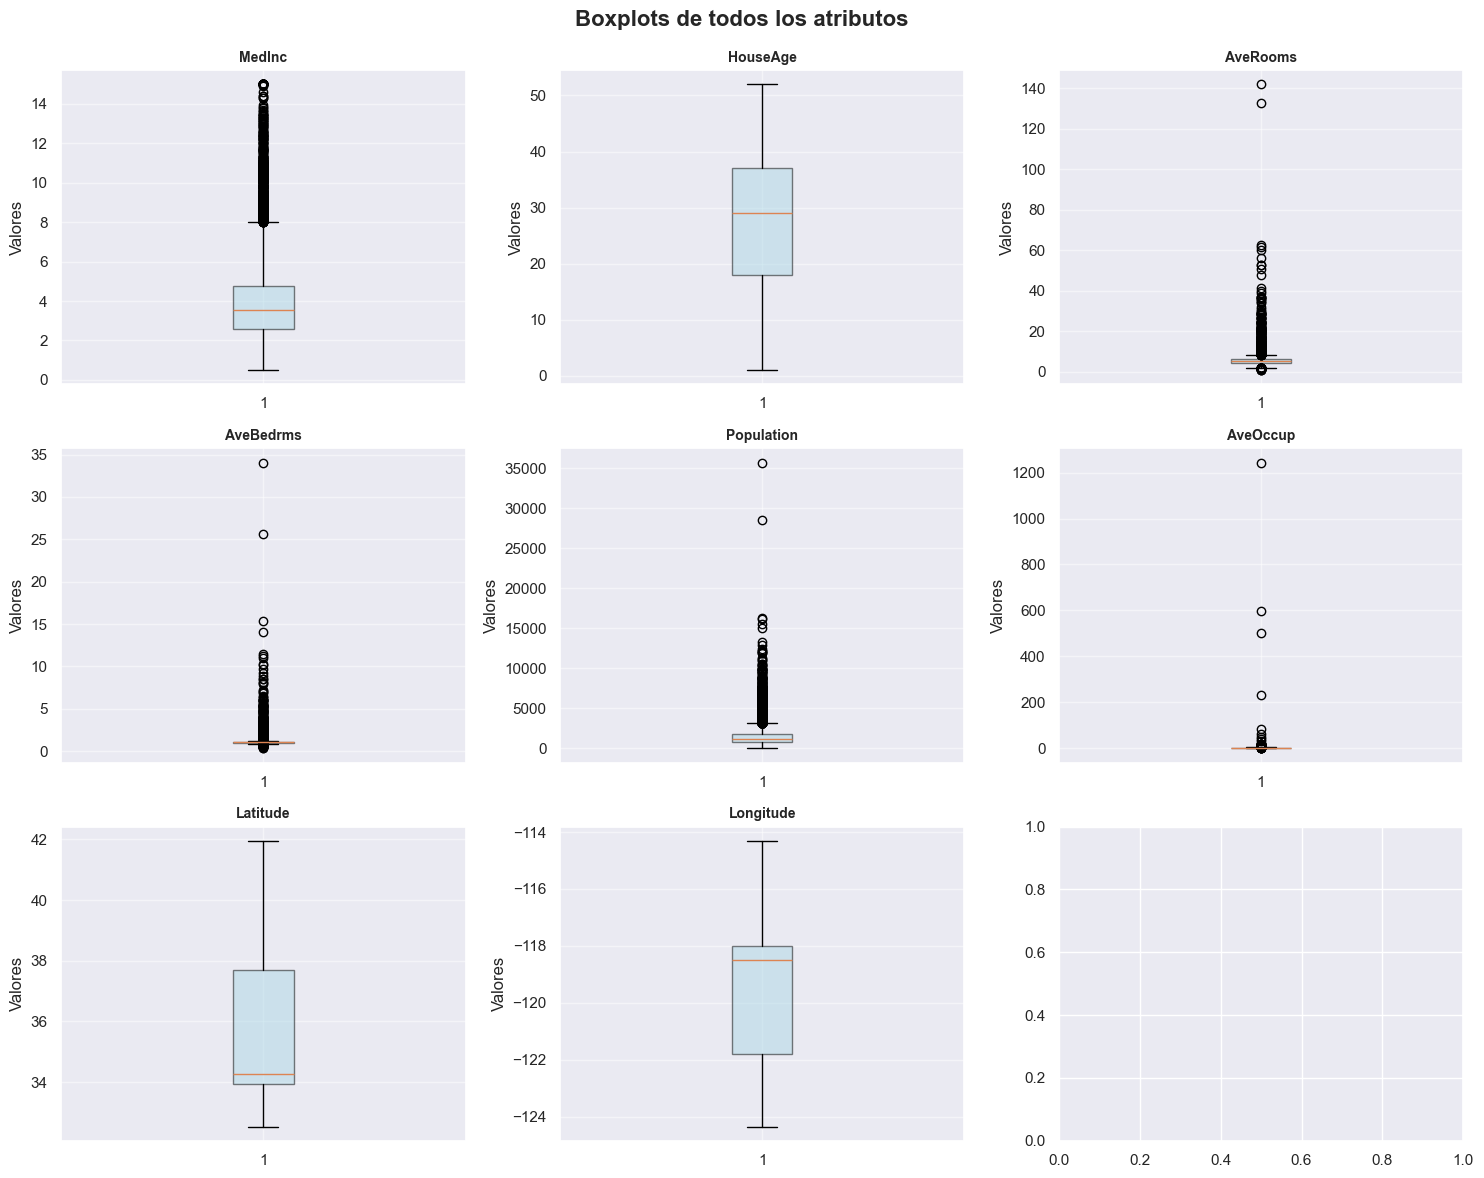

In [48]:
# Boxplots de todas las features
features = X.columns
n_features = len(features)

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() if n_features > 1 else [axes]

for i, feature in enumerate(features):
    axes[i].boxplot(X[feature], patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.5))
    axes[i].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[i].set_ylabel('Valores')
    axes[i].grid(True, alpha=0.5)

plt.suptitle('Boxplots de todos los atributos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [49]:
# Reemplazamos los outliers por la mediana de cada feature
def replace_outliers(df, multiplier=1.5):
    """
    Reemplaza outliers extremos por la mediana de cada feature usando método IQR.
    
    Parameters:
    df: DataFrame a procesar
    multiplier: multiplicador del IQR para detectar outliers
    """
    df_copy = df.copy()
    for col in df_copy.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        outliers_count = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)).sum()
        total_count = len(df_copy[col])
        outliers_pct = (outliers_count / total_count) * 100
        
        print(f"{col}: {outliers_count} outliers extremos ({outliers_pct:.2f}% del total)")
        
        df_copy[col] = np.where((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound), 
                               df_copy[col].median(), df_copy[col])
    return df_copy

X_cleaned = replace_outliers(X, multiplier=5)  # El valor del multiplier lo determinamos probando diferentes valores y evaluando su impacto en las métricas del modelo

X = X_cleaned

MedInc: 0 outliers extremos (0.00% del total)
HouseAge: 0 outliers extremos (0.00% del total)
AveRooms: 120 outliers extremos (0.58% del total)
AveBedrms: 443 outliers extremos (2.15% del total)
Population: 159 outliers extremos (0.77% del total)
AveOccup: 62 outliers extremos (0.30% del total)
Latitude: 0 outliers extremos (0.00% del total)
Longitude: 0 outliers extremos (0.00% del total)


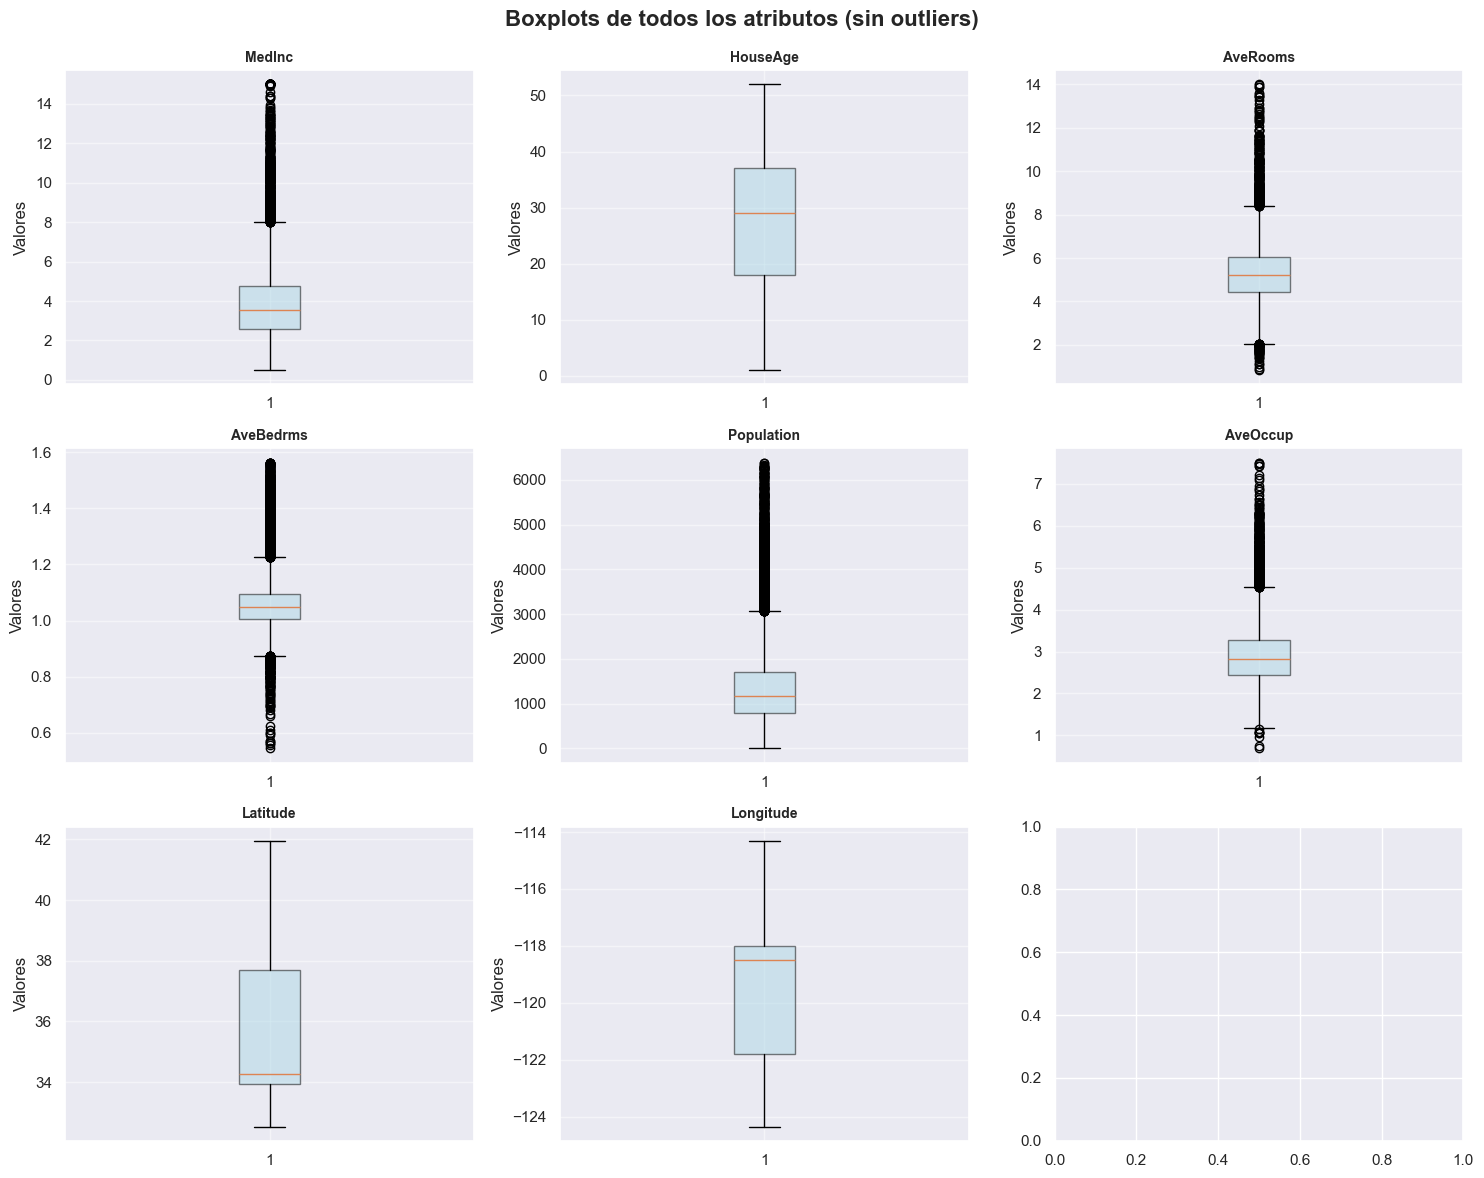

In [50]:
# Boxplots de todas las features (sin outliers)
features = X.columns
n_features = len(features)

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten() if n_features > 1 else [axes]

for i, feature in enumerate(features):
    axes[i].boxplot(X[feature], patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.5))
    axes[i].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[i].set_ylabel('Valores')
    axes[i].grid(True, alpha=0.5)

plt.suptitle('Boxplots de todos los atributos (sin outliers)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

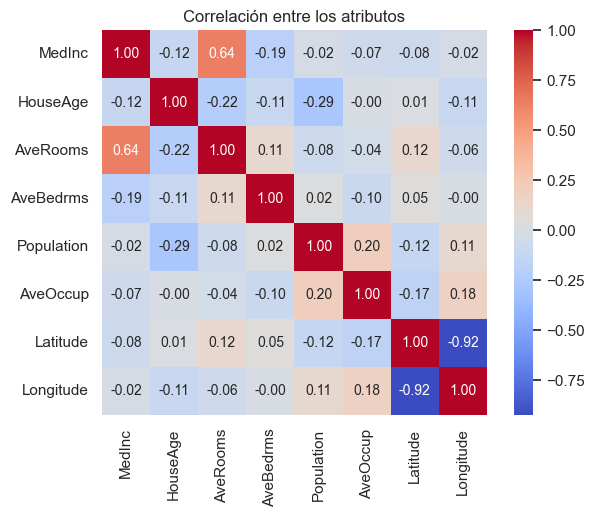

In [51]:
# Calculamos la correlación entre los features
correlacion_features = X.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(
    correlacion_features, 
    annot=True,
    cmap='coolwarm',
    annot_kws={"size": 10},
    fmt=".2f",
    square=True,
    cbar=True
    )
plt.title('Correlación entre los atributos')
plt.show()

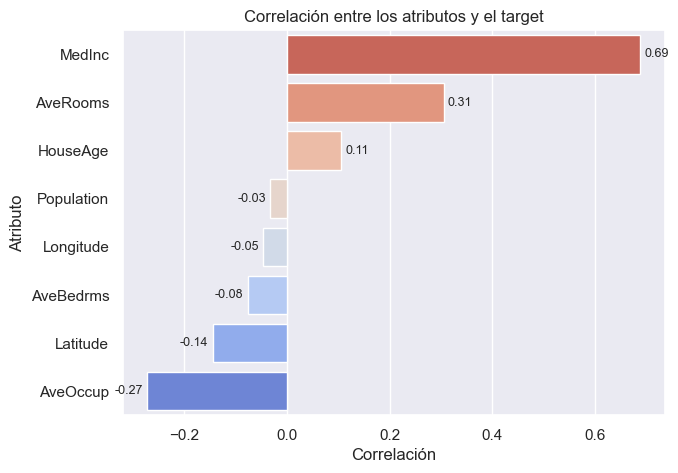

In [52]:
# Correlación entre los features y el target
df_complete = pd.concat([X, y], axis=1)
correlation_with_target = (
    df_complete.corr()[['MedHouseVal']]
    .sort_values(by='MedHouseVal', ascending=False)
    .iloc[1:]
)

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=correlation_with_target.MedHouseVal,
    y=correlation_with_target.index,
    hue=correlation_with_target.index,
    palette='coolwarm_r',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)
    
plt.title('Correlación entre los atributos y el target')
plt.xlabel('Correlación')
plt.ylabel('Atributo')
plt.show()

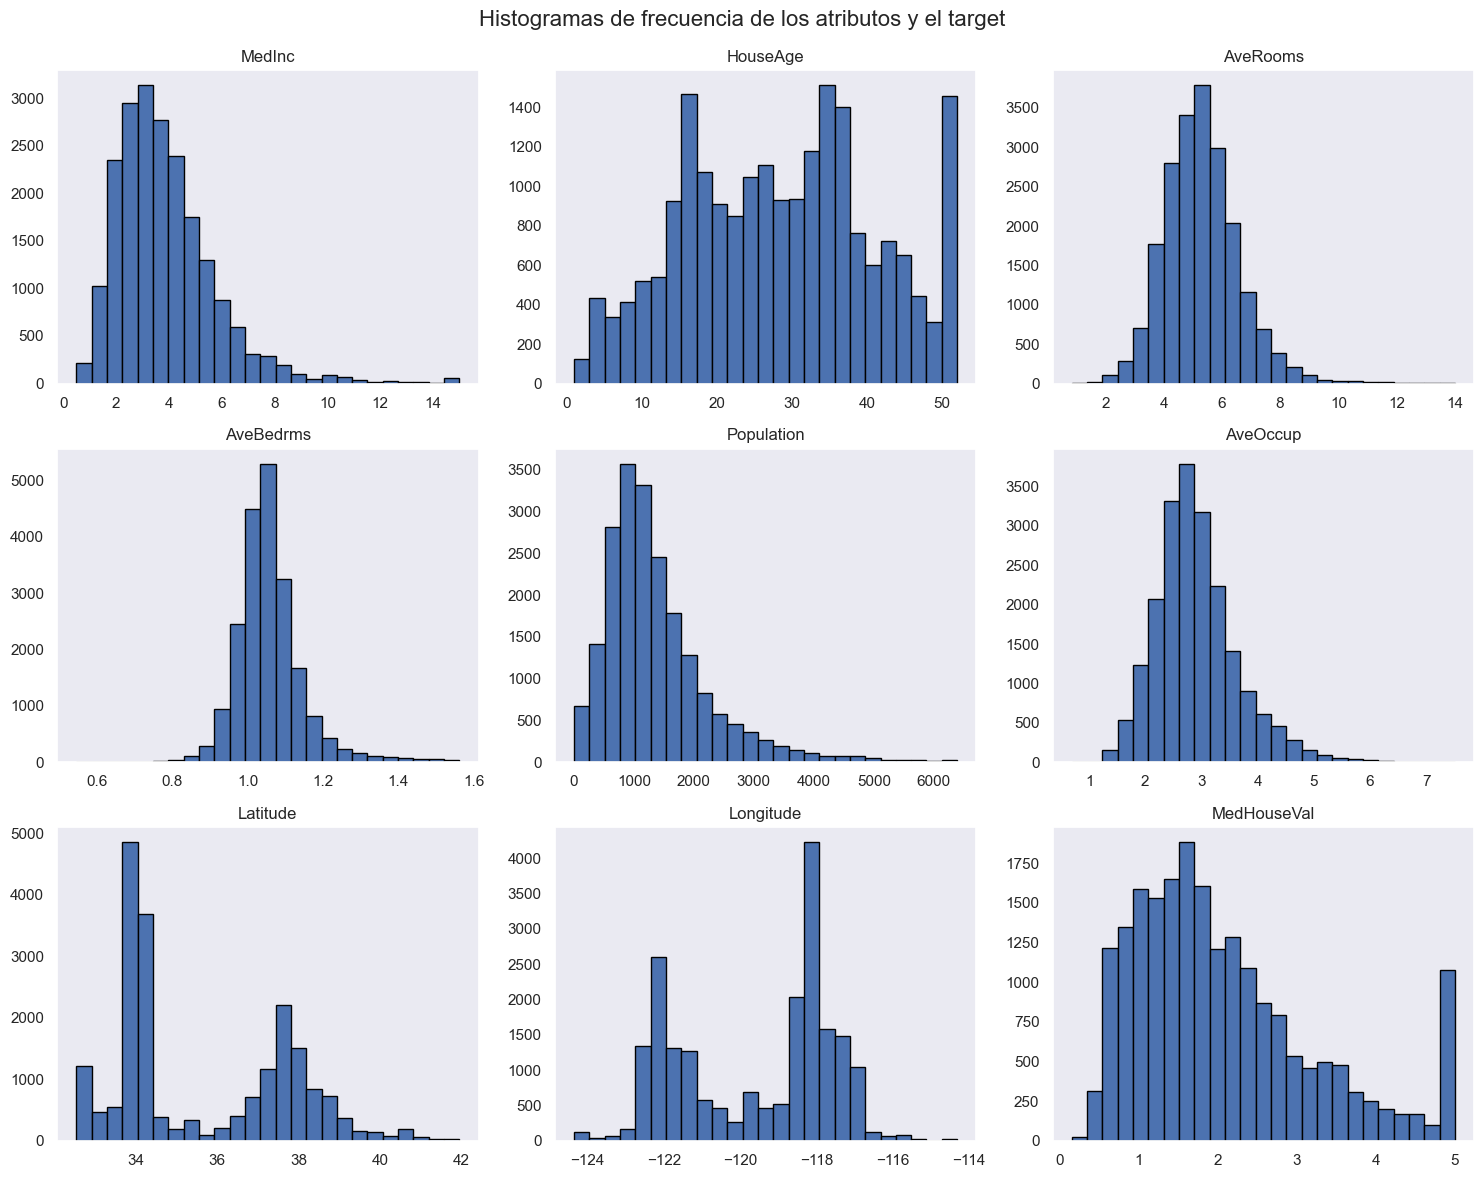

In [53]:
# Histogramas de todos los atributos y el target
df_cleaned = pd.concat([X, y], axis=1)

df_cleaned.hist(bins=25, figsize=(15, 12), edgecolor='black', grid=False)
plt.suptitle("Histogramas de frecuencia de los atributos y el target", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

División en entrenamiento y evaluación

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimensión de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimensión de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimensión de X_train: (14448, 8)
Valores de y_train: 14448
Dimensión de X_test: (6192, 8)
Valores de y_test: 6192


In [55]:
# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

In [56]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.432929,-0.899240,-0.171287,0.103692,-0.805682,0.780934
1,-0.532218,-0.679873,-0.698001,0.199825,-0.415713,-1.212521,-1.339473,1.245270
2,0.170990,-0.362745,0.230733,-0.747259,-0.714827,-0.466039,-0.496645,-0.277552
3,-0.402916,-1.155565,0.423165,0.391004,-1.193632,-0.976307,1.690024,-0.706938
4,-0.299285,1.857152,-0.392584,0.087358,0.172470,-0.827516,0.992350,-1.430902


### Regresión Lineal

In [57]:
# Regresión lineal utilizando todos los atributos.

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [58]:
# Predicciones para el conjunto de entrenamiento
y_pred_model = linear_model.predict(X_train_scaled)

In [59]:
# Varianza total del modelo y la varianza explicada por el modelo con el conjunto de entrenamiento
y_mean = np.mean(y_train)

var_model = np.sum((y_train - y_mean) ** 2)
explained_var_model = np.sum((y_pred_model - y_mean) ** 2)

print(f"Varianza total del modelo {round(var_model, 3)}")
print(f"Varianza explicada por del modelo {round(explained_var_model, 3)}")

print(f"El coeficiente de determinación (R^2): {explained_var_model/var_model}")

Varianza total del modelo 19355.927
Varianza explicada por del modelo 12747.389
El coeficiente de determinación (R^2): 0.6585780482923699


In [60]:
# Predicciones para el conjunto de evaluación
y_pred = linear_model.predict(X_test_scaled)

In [61]:
# Métricas de MSE, MAE y R² sobre el conjunto de evaluación.

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))

R-cuadrado en test: 0.655
Error absoluto medio: 0.497
Error cuadrático medio: 0.452


### Regresión de Ridge

Ejemplo de validación cruzada

- Usamos el método de 5 folds
- Utilizamos el MSE. [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) devuelve el valor negativo por cuestiones de compatibilidad con otras funciones de la biblioteca.

In [62]:
# Creamos un modelo
alpha = 1.0
ridge_model = Ridge(alpha=alpha)

cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)

# Este cálculo nos devuelve el valor del MSE para cada uno de los folds.
cv

array([-0.47388837, -0.43654652, -0.45174743, -0.45055491, -0.47670376])

Podemos obtener la media y el desvío estándar de los errores:

In [63]:
print(f"La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha={alpha} es {(-1)*cv.mean()}")
print(f"El desvío estándar del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha={alpha} es {cv.std()}")

La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha=1.0 es 0.4578881977618369
El desvío estándar del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha=1.0 es 0.015211732284253278


### Búsqueda de hiperparámetros

Aquí generamos varios valores de alpha para la búsqueda solicitada en el TP:

In [64]:
alpha_values = np.linspace(0, 12.5, 100)
alpha_values

array([ 0.        ,  0.12626263,  0.25252525,  0.37878788,  0.50505051,
        0.63131313,  0.75757576,  0.88383838,  1.01010101,  1.13636364,
        1.26262626,  1.38888889,  1.51515152,  1.64141414,  1.76767677,
        1.89393939,  2.02020202,  2.14646465,  2.27272727,  2.3989899 ,
        2.52525253,  2.65151515,  2.77777778,  2.9040404 ,  3.03030303,
        3.15656566,  3.28282828,  3.40909091,  3.53535354,  3.66161616,
        3.78787879,  3.91414141,  4.04040404,  4.16666667,  4.29292929,
        4.41919192,  4.54545455,  4.67171717,  4.7979798 ,  4.92424242,
        5.05050505,  5.17676768,  5.3030303 ,  5.42929293,  5.55555556,
        5.68181818,  5.80808081,  5.93434343,  6.06060606,  6.18686869,
        6.31313131,  6.43939394,  6.56565657,  6.69191919,  6.81818182,
        6.94444444,  7.07070707,  7.1969697 ,  7.32323232,  7.44949495,
        7.57575758,  7.7020202 ,  7.82828283,  7.95454545,  8.08080808,
        8.20707071,  8.33333333,  8.45959596,  8.58585859,  8.71

In [65]:
# Búsqueda del mejor alpha
cv_ridge_errors = []

for alpha in alpha_values:

    ridge_model = Ridge(alpha=alpha)
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)

    # Calcular el error medio para este alpha
    cv_ridge_errors.append((-1)*cv.mean())

# Mostramos cual es el mejor valor de alpha para cada caso
best_alpha_ridge = alpha_values[np.argmin(cv_ridge_errors)]
print(f"El mejor valor de alpha para Ridge es: {best_alpha_ridge}")

El mejor valor de alpha para Ridge es: 2.1464646464646466


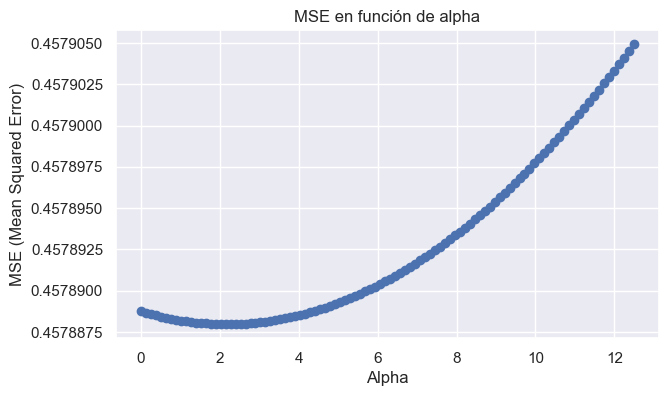

In [66]:
# Grafico de MSE en función de alpha
plt.figure(figsize=(7,4))
plt.plot(alpha_values, cv_ridge_errors, marker='o')
plt.xlabel("Alpha")
plt.ylabel("MSE (Mean Squared Error)")
plt.title("MSE en función de alpha")
plt.grid(True)
plt.show()

In [67]:
# Entrenamos el modelo con el mejor alpha
ridge_model = Ridge(alpha=best_alpha_ridge)

ridge_model.fit(X_train_scaled, y_train)

,alpha,np.float64(2.1464646464646466)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [68]:
# Predicciones con el conjunto de evaluación
y_pred = ridge_model.predict(X_test_scaled)

In [69]:
# Métricas de MSE, MAE y R² sobre el conjunto de evaluación.

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))


R-cuadrado en test: 0.655
Error absoluto medio: 0.497
Error cuadrático medio: 0.452


### Comparación de modelos

|                    | $R^2$      | MAE ($)   | MSE ($) |
|--------------------|------------|-----------|----------|
| Regresión Lineal   | 0.655      | 0.497      | 0.452     |
| Regresión de Ridge |  0.655      | 0.497      | 0.452   |

### Conclusión

La limpieza de outliers extremos en las variables del dataset permitió mejorar las métricas de los modelos de regresión lineal y Ridge. Al reemplazar los valores atípicos por la mediana, se redujo el impacto de datos anómalos en el ajuste y la predicción, logrando un menor error cuadrático medio (MSE) y error absoluto medio (MAE), así como un mayor coeficiente de determinación ($R^2$).